In [1]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
#import herschelhelp.cutouts_server as ctts

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
#from herschelhelp import image_plotting
import pyvo as vo
import glob

import copy
from pymoc.io.fits import read_moc_fits

In [ ]:
def find_prior_file(helpid,index):

In [2]:
lofar_orig = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mips_prior = Table.read('data/data_release/xidplus_prior_cat_MIPS_rerun.fits')
pacs_prior = Table.read('data/data_release/xidplus_prior_cat_rerun_mips.fits')

#read in the HELP catalogue
masterlist = Table.read('../../../../../HELP/dmu_products/dmu32/dmu32_Bootes/data/Bootes_20190701_cigale.fits')

In [233]:
xid_help_pacs = Table.read('../../../../../HELP/dmu_products/dmu26/dmu26_XID+PACS_Bootes/data/dmu26_XID+PACS_Bootes_cat_20190425.fits')
xid_lofar_fir = Table.read('data/fir/PACS/all_sources.fits')

#create index of files for stan run
ind = 0
before = 1
now = 1
index_numpyro = []
for n,helpid in enumerate(xid_lofar_fir['help_id']):

    
    if 'HELP' in helpid:
        now = 1
    elif 'ILTJ' in helpid:
        now = 2

    
    if now-before == 1:
        ind = ind + 1
        
    index_numpyro.append(ind)
    before = now
    
index_numpyro = np.array(index_numpyro)

In [43]:
taskid = 10
batch_size = 20

if taskid*batch_size>len(lofar_orig):
    print('Task id is too high. Trying to run code on more sources than exist')
    sys.exit()
ind_low = taskid*batch_size
if taskid*batch_size+batch_size>len(lofar_orig):
    ind_up = len(lofar_orig)
else:
    ind_up = taskid*batch_size+batch_size
ras = lofar_orig['optRA'][ind_low:ind_up]
mask = np.isnan(ras)
ras[mask] = lofar_orig['RA'][ind_low:ind_up][mask]

decs = lofar_orig['optDec'][ind_low:ind_up]
mask = np.isnan(decs)
decs[mask] = lofar_orig['DEC'][ind_low:ind_up][mask]

ids = lofar_orig['Source_Name'][ind_low:ind_up]

In [74]:
file_list = glob.glob('data/fir/PACS/v2_numpyro/*/lofar_xidplus*.pkl')
file_list.sort()

In [75]:
file_list

['data/fir/PACS/v2_numpyro/xidplus_run_0/lofar_xidplus_fir_0.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_1/lofar_xidplus_fir_1.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_10/lofar_xidplus_fir_10.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_100/lofar_xidplus_fir_100.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_101/lofar_xidplus_fir_101.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_102/lofar_xidplus_fir_102.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_103/lofar_xidplus_fir_103.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_104/lofar_xidplus_fir_104.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_105/lofar_xidplus_fir_105.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_106/lofar_xidplus_fir_106.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_107/lofar_xidplus_fir_107.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_108/lofar_xidplus_fir_108.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_109/lofar_xidplus_fir_109.pkl',
 'data/fir/PACS/v2_numpyro/xidplus_run_11/lofar_xidplus_fir_11.pkl',
 'data/fir/PACS/v2

In [120]:
file_list_numpyro = glob.glob('data/fir/PACS/v2_numpyro/*/lofar_xidplus*.pkl')
file_list_numpyro.sort()

priors,posterior = xidplus.load(file_list_numpyro[2])
PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
lofar_pacs_table_numpyro = Table.read(PACS_cat,memmap=False)

for i,filename in enumerate(file_list_numpyro):
    #print(filename)
    if i%50==0:
        print(i)
    
    priors,posterior = xidplus.load(filename)
    PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
    PACS_cat = Table.read(PACS_cat,memmap=False)
    lofar_pacs_table_numpyro = vstack([lofar_pacs_table_numpyro,PACS_cat])

0
50
100
150
200


In [247]:
#create index of files for stan run
ind = 0
before = 1
now = 1
index_numpyro = []
for n,helpid in enumerate(lofar_pacs_table_numpyro['help_id']):
    
    if 'HELP' in helpid:
        now = 1
    elif 'ILTJ' in helpid:
        now = 2

    
    if now-before == 1:
        ind = ind + 1
        
    index_numpyro.append(ind)
    before = now
    
index_numpyro = np.array(index_numpyro)

In [168]:
file_list_stan = glob.glob('data/fir/PACS/xidplus_*/lofar_xidplus*.pkl')
file_list_stan.sort()

priors,posterior = xidplus.load(file_list_stan[0])
PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
lofar_pacs_table_stan = Table.read(PACS_cat,memmap=False)

for i,filename in enumerate(file_list_stan[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    priors,posterior = xidplus.load(filename)
    PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
    PACS_cat = Table.read(PACS_cat,memmap=False)
    lofar_pacs_table_stan = vstack([lofar_pacs_table_stan,PACS_cat])

0
50
100
150
200


In [235]:
ind = 0
before = 1
now = 1
index_stan = []
for n,helpid in enumerate(lofar_pacs_table_stan['help_id']):

    
    if 'HELP' in helpid:
        now = 1
    elif 'ILTJ' in helpid:
        now = 2

    
    if now-before == 1:
        ind = ind + 1
        
    index_stan.append(ind)
    before = now
    
index_stan = np.array(index_stan)

In [202]:
len(lofar_pacs_table_stan)

28782

1.0


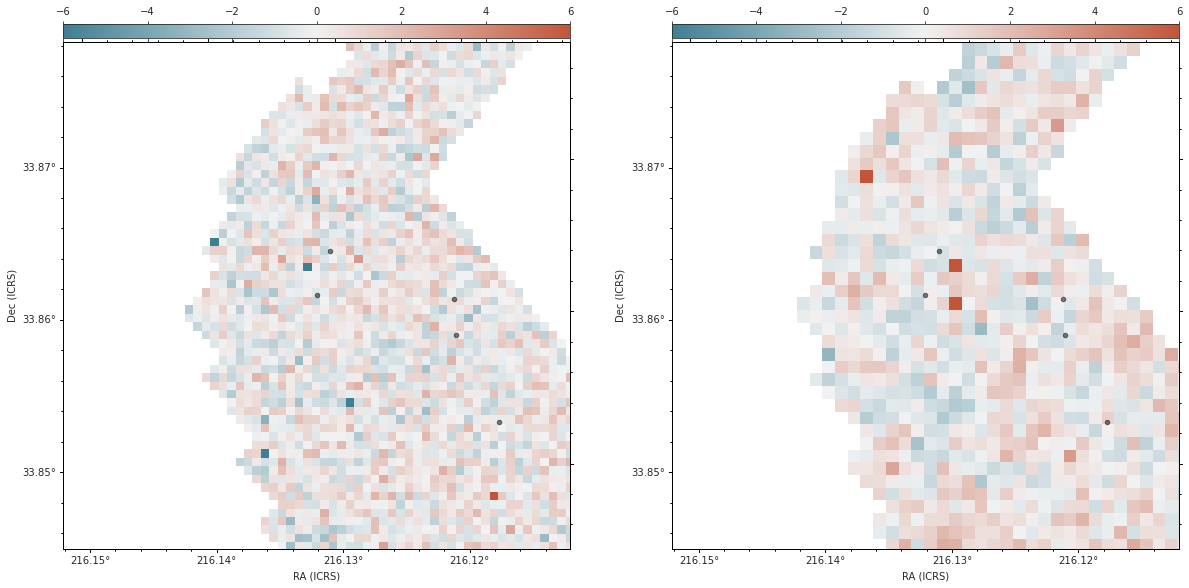

1.0
1.0


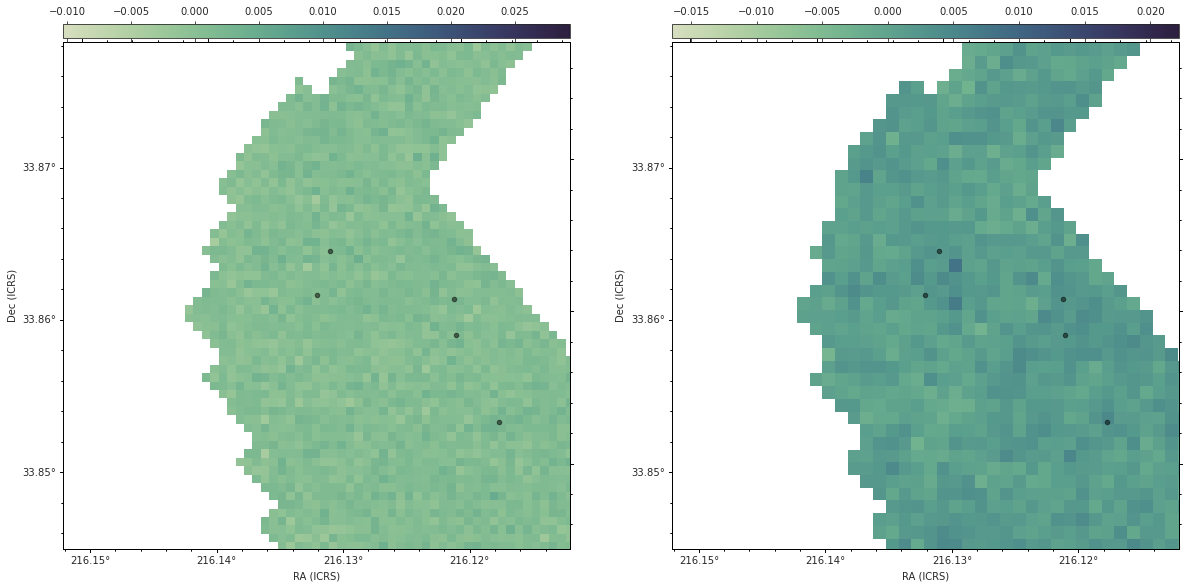

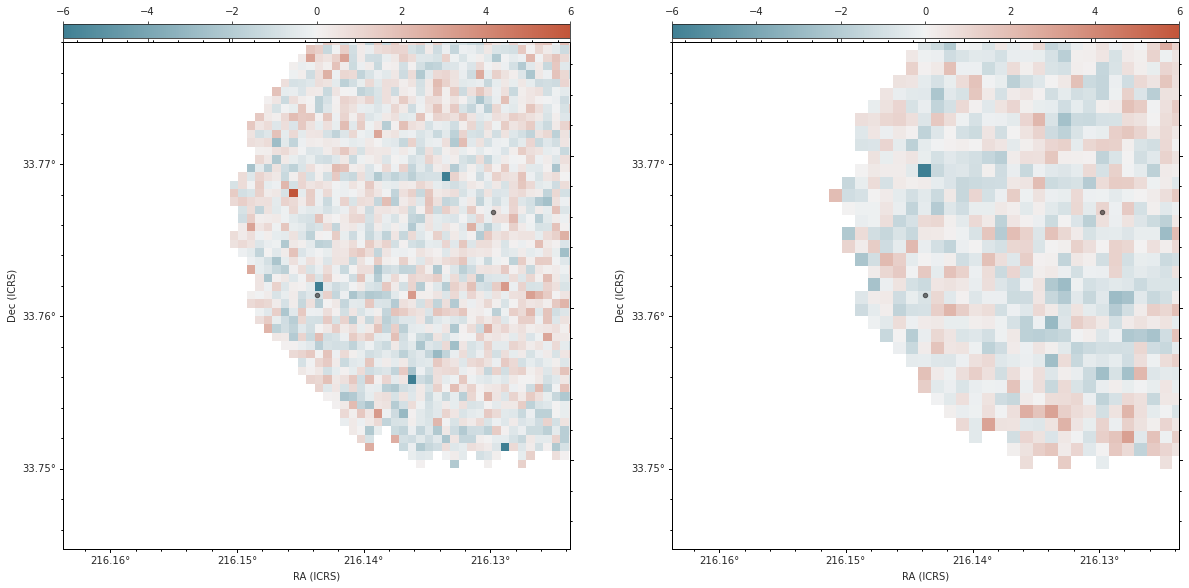

1.0
1.0


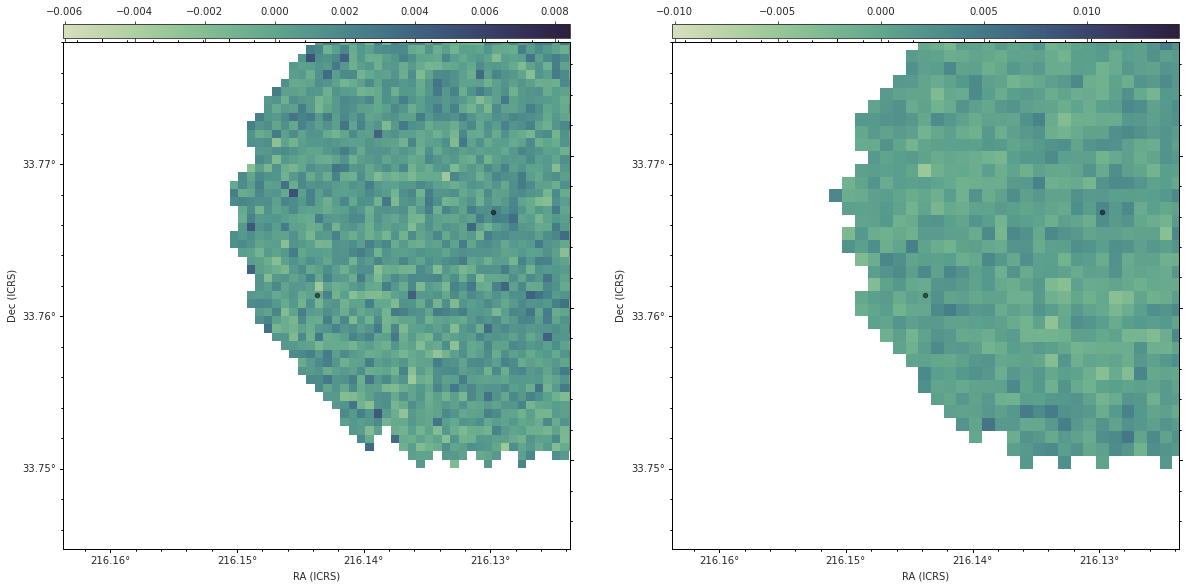

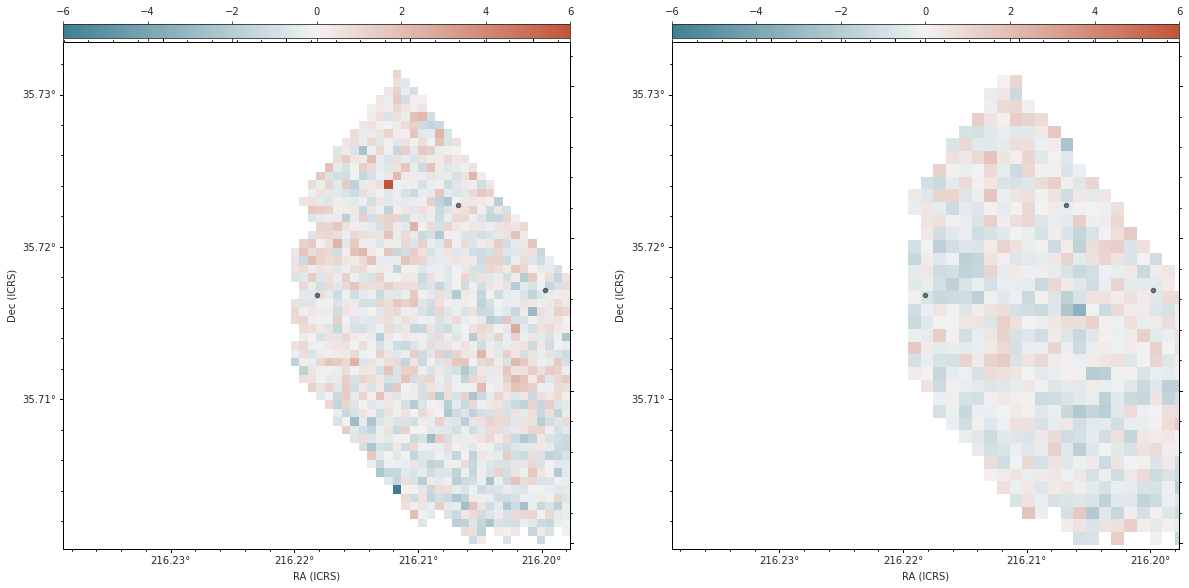

1.0
0.63


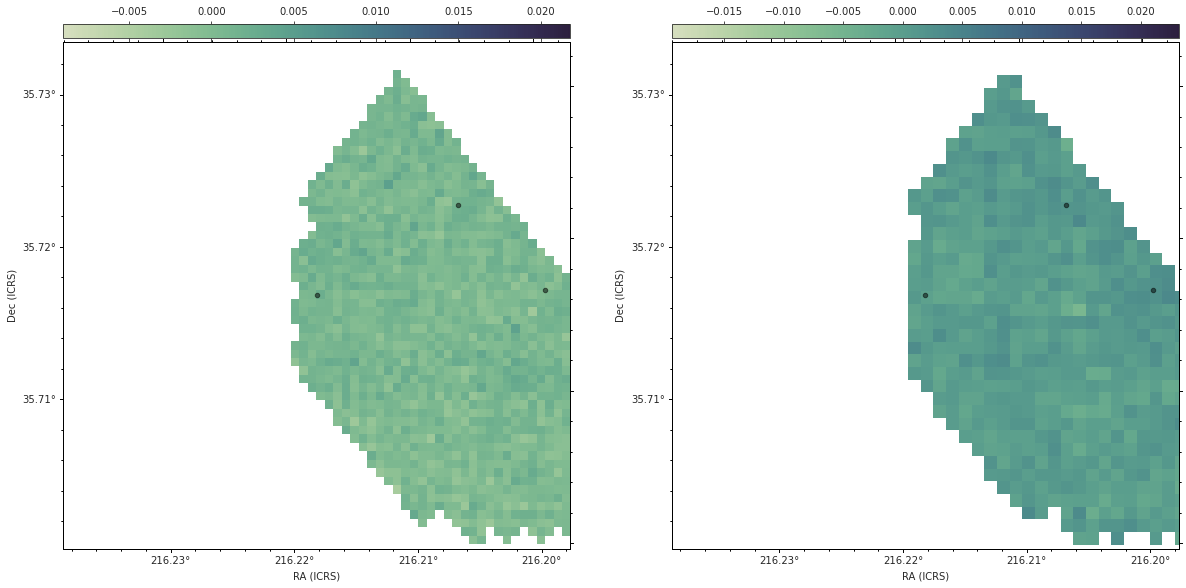

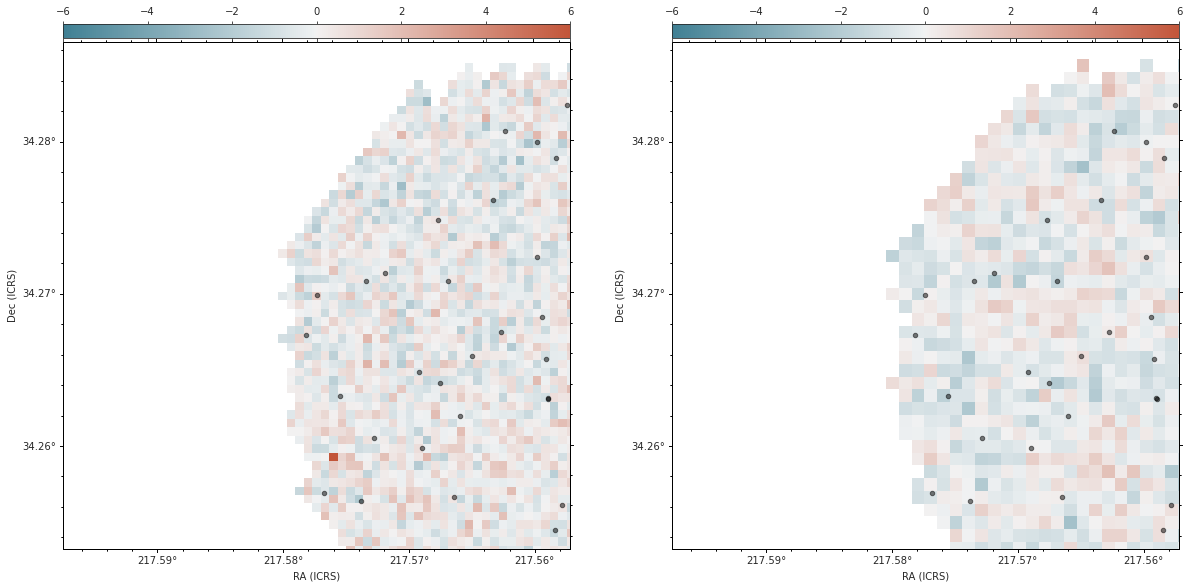

0.63
0.962


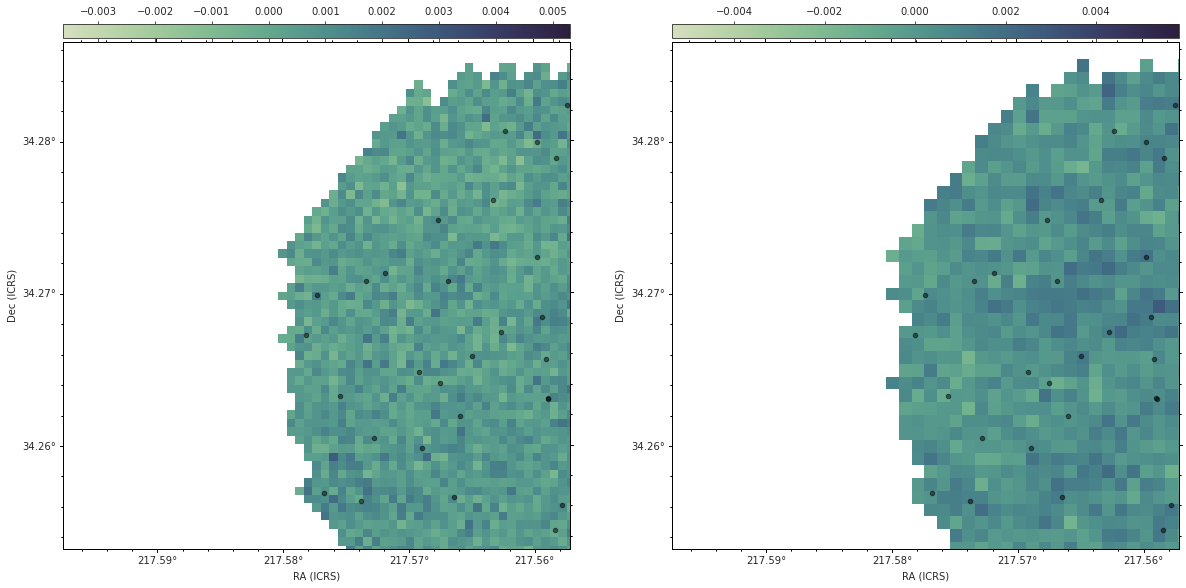

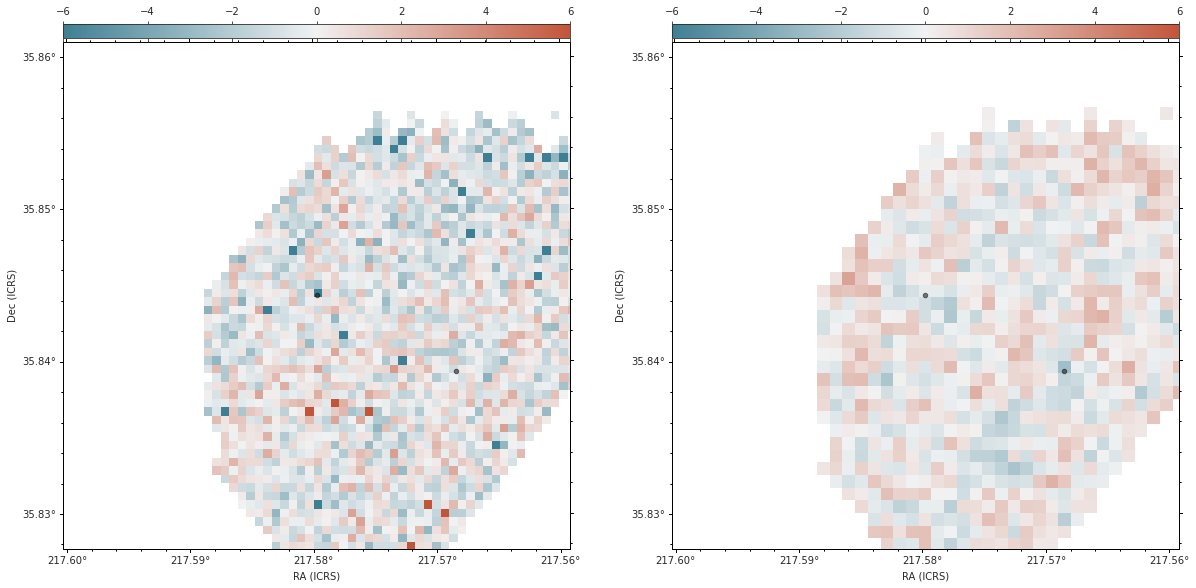

0.962


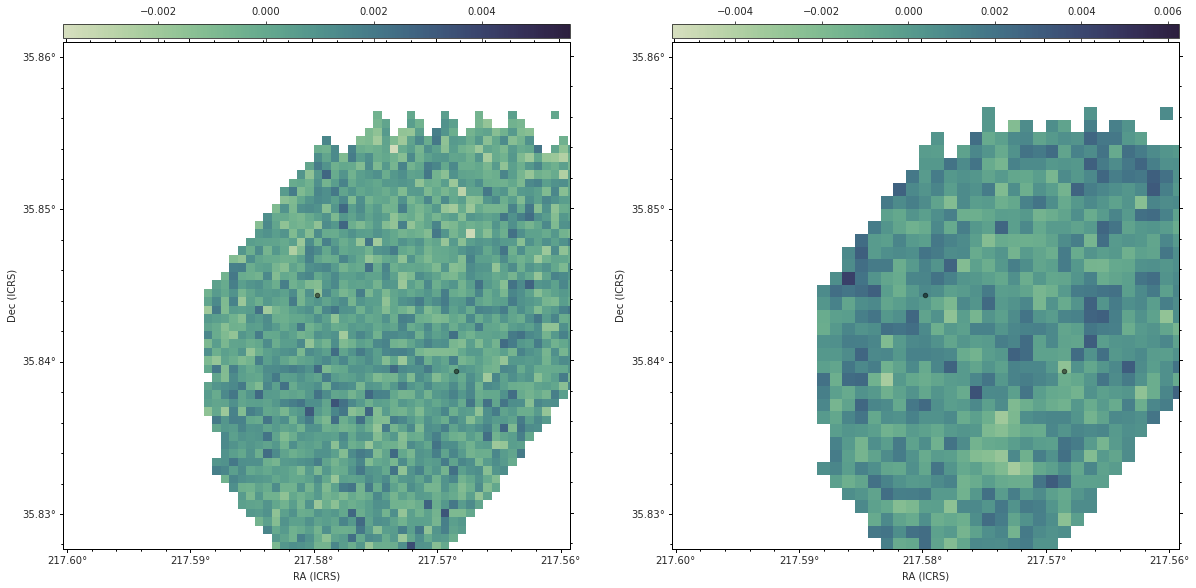

In [78]:
file_list = glob.glob('data/fir/PACS/v2_numpyro/*/lofar_xidplus*.pkl')
file_list.sort()

for filename in file_list[:5]:
    priors,posterior = xidplus.load(filename)
    PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
    PACS_cat = Table.read(PACS_cat,memmap=False)
    figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)
    ra = PACS_cat['RA'][-1]
    dec = PACS_cat['Dec'][-1]
    print(PACS_cat['Pval_res_160'][-1])
    figs[0].recenter(ra,dec,radius=1/60)
    figs[1].recenter(ra,dec,radius=1/60)
    plt.show()
    
    figs, fig=xidplus.plot_map(priors)
    ra = PACS_cat['RA'][-1]
    dec = PACS_cat['Dec'][-1]
    print(PACS_cat['Pval_res_160'][-1])
    figs[0].recenter(ra,dec,radius=1/60)
    figs[1].recenter(ra,dec,radius=1/60)

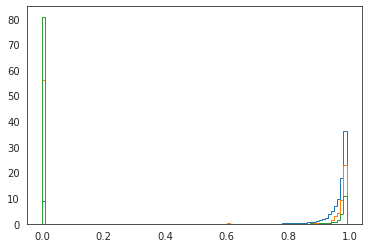

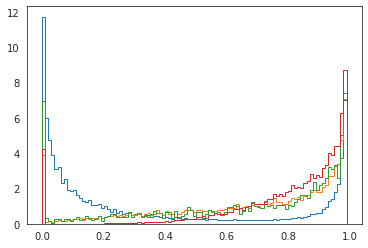

In [121]:
bins = np.arange(0,1,0.01)
plt.hist(xid_help_pacs['Pval_res_100'],bins=bins,density=True,histtype='step')
plt.hist(xid_lofar_fir['Pval_res_100'],bins=bins,density=True,histtype='step')
plt.hist(lofar_pacs_table_numpyro['Pval_res_100'],bins=bins,density=True,histtype='step')
plt.show()

bins = np.arange(0,1,0.01)
plt.hist(xid_help_pacs['Pval_res_160'],bins=bins,density=True,histtype='step')
plt.hist(xid_lofar_fir['Pval_res_160'],bins=bins,density=True,histtype='step')
mask = np.array(['ILTJ' in name for name in xid_lofar_fir['help_id']])
plt.hist(xid_lofar_fir['Pval_res_160'][mask],bins=bins,density=True,histtype='step')
plt.hist(lofar_pacs_table_numpyro['Pval_res_160'],bins=bins,density=True,histtype='step')
plt.show()

In [13]:
rep_maps = xidplus.posterior_maps.replicated_maps(priors,posterior)
pval_map = xidplus.posterior_maps.make_Bayesian_pval_maps(priors[1],rep_maps[1])

In [19]:
ind= priors[1].amat_col == priors[1].nsrc-1
np.sum(pval_map[priors[1].amat_row[ind]])

-36.995163

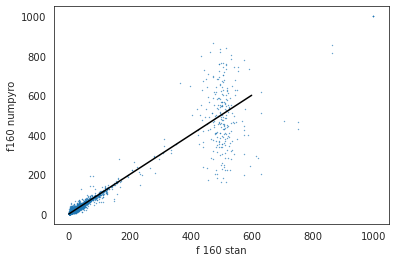

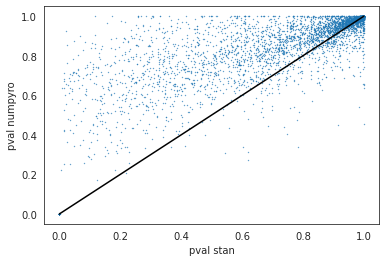

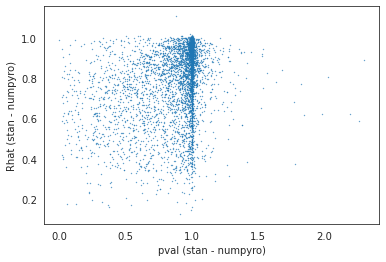

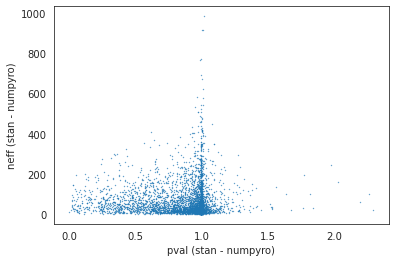

In [263]:
joined_lofar_numpyro = join(lofar_pacs_table_stan,lofar_pacs_table_numpyro,keys='help_id')

mask = np.array(['ILTJ' in name for name in joined_lofar_numpyro['help_id']])
x = joined_lofar_numpyro['F_PACS_160_1'][mask]
y = joined_lofar_numpyro['F_PACS_160_2'][mask]
plt.scatter(x,y,s=0.1)

plt.plot([0,600],[0,600],c='black')
plt.xlabel('f 160 stan')
plt.ylabel('f160 numpyro')
plt.show()

x = joined_lofar_numpyro['Pval_res_160_1'][mask]
y = joined_lofar_numpyro['Pval_res_160_2'][mask]
plt.scatter(x,y,s=0.1)

plt.plot([0,1],[0,1],c='black')
plt.xlabel('pval stan')
plt.ylabel('pval numpyro')
plt.show()

x = joined_lofar_numpyro['Pval_res_160_1'][mask] / joined_lofar_numpyro['Pval_res_160_2'][mask]
y = joined_lofar_numpyro['Rhat_PACS_160_1'][mask] / joined_lofar_numpyro['Rhat_PACS_160_2'][mask]
plt.scatter(x,y,s=0.1)

plt.xlabel('pval (stan - numpyro)')
plt.ylabel('Rhat (stan - numpyro)')
plt.show()


x = joined_lofar_numpyro['Pval_res_160_1'][mask] / joined_lofar_numpyro['Pval_res_160_2'][mask]
y = joined_lofar_numpyro['n_eff_PACS_160_1'][mask] / joined_lofar_numpyro['n_eff_PACS_160_2'][mask]
plt.scatter(x,y,s=0.1)

plt.xlabel('pval (stan - numpyro)')
plt.ylabel('neff (stan - numpyro)')
plt.show()

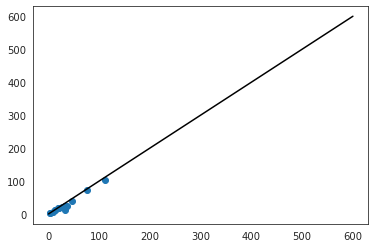

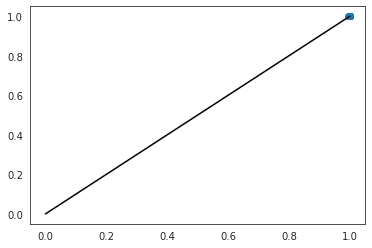

In [81]:
joined_lofar_numpyro = join(lofar_pacs_table_stan,lofar_pacs_table_numpyro,keys='help_id')

mask = np.array(['ILTJ' in name for name in joined_lofar_numpyro['help_id']])
x = joined_lofar_numpyro['F_PACS_160_1'][mask]
y = joined_lofar_numpyro['F_PACS_160_2'][mask]
plt.scatter(x,y)

plt.plot([0,600],[0,600],c='black')
plt.show()

x = joined_lofar_numpyro['Pval_res_160_1'][mask]
y = joined_lofar_numpyro['Pval_res_160_2'][mask]
plt.scatter(x,y)

plt.plot([0,1],[0,1],c='black')
plt.show()

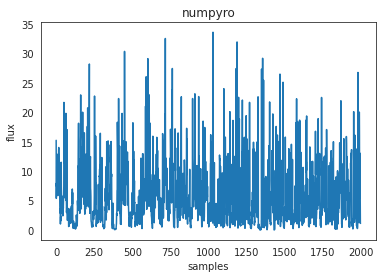

In [114]:
file_list = glob.glob('data/fir/PACS/v2_numpyro/xidplus_run_10/lofar_xidplus*.pkl')
file_list.sort()

priors,posterior = xidplus.load(file_list[0])
PACS_cat_numpyro_single = cat.create_PACS_cat(posterior,priors[0],priors[1])
PACS_cat_numpyro_single = Table.read(PACS_cat_numpyro_single,memmap=False)

y = posterior.samples['src_f'][:,1,-1]
x = np.arange(0,len(y),1)
plt.plot(x,y)
plt.title('numpyro')
plt.xlabel('samples')
plt.ylabel('flux')
plt.show()

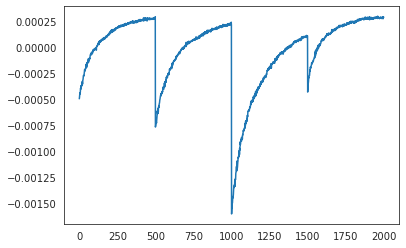

In [96]:
posterior.samples['bkg'].shape
y = posterior.samples['bkg'][:,1]
x = np.arange(0,len(y),1)
plt.plot(x,y)

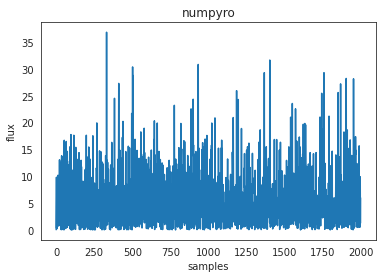

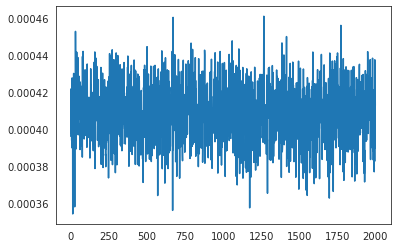

In [113]:
file_list = glob.glob('data/fir/PACS/v2/xidplus_run_10/lofar_xidplus*.pkl')
file_list.sort()

priors,posterior = xidplus.load(file_list[0])
PACS_cat_stan_single = cat.create_PACS_cat(posterior,priors[0],priors[1])
PACS_cat_stan_single = Table.read(PACS_cat_stan_single,memmap=False)

y = posterior.samples['src_f'][:,1,-1]
x = np.arange(0,len(y),1)
plt.plot(x,y)
plt.title('numpyro')
plt.xlabel('samples')
plt.ylabel('flux')
plt.show()


y = posterior.samples['bkg'][:,1]
x = np.arange(0,len(y),1)
plt.plot(x,y)
plt.show()

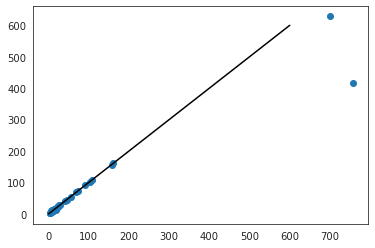

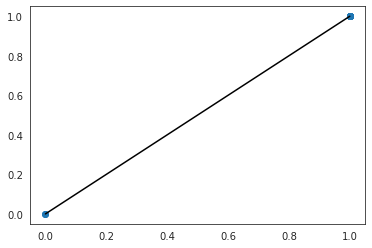

In [116]:
joined = join(PACS_cat_numpyro_single,PACS_cat_stan_single,keys='help_id')

mask = np.array(['ILTJ' in name for name in joined['help_id']])
x = joined['F_PACS_160_1'][mask]
y = joined['F_PACS_160_2'][mask]
plt.scatter(x,y)

plt.plot([0,600],[0,600],c='black')
plt.show()

x = joined['Pval_res_160_1'][mask]
y = joined['Pval_res_160_2'][mask]
plt.scatter(x,y)

plt.plot([0,1],[0,1],c='black')
plt.show()

In [134]:
joined_lofar_numpyro

help_id,RA_1,Dec_1,F_PACS_100_1,FErr_PACS_100_u_1,FErr_PACS_100_l_1,F_PACS_160_1,FErr_PACS_160_u_1,FErr_PACS_160_l_1,Bkg_PACS_100_1,Bkg_PACS_160_1,Sig_conf_PACS_100_1,Sig_conf_PACS_160_1,Rhat_PACS_100_1,Rhat_PACS_160_1,n_eff_PACS_100_1,n_eff_PACS_160_1,Pval_res_100_1,Pval_res_160_1,RA_2,Dec_2,F_PACS_100_2,FErr_PACS_100_u_2,FErr_PACS_100_l_2,F_PACS_160_2,FErr_PACS_160_u_2,FErr_PACS_160_l_2,Bkg_PACS_100_2,Bkg_PACS_160_2,Sig_conf_PACS_100_2,Sig_conf_PACS_160_2,Rhat_PACS_100_2,Rhat_PACS_160_2,n_eff_PACS_100_2,n_eff_PACS_160_2,Pval_res_100_2,Pval_res_160_2
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J142425.392+352817.910,216.10579867176133,35.47164159661502,9.386864,18.83923,2.8484492,3.5494058,9.130841,0.88432837,0.00065558014,0.00063276774,0.0010354471,0.0012038929,1.0005858,1.0006275,1735.3428,2457.4385,1.0,1.0,216.10579867176133,35.47164159661502,6.3558226,13.111052,1.942089,2.7356448,6.625387,0.69694114,0.0006204441,0.00064042653,0.0010294018,0.0011968343,1.0086728,1.0057707,369.63882,518.58606,1.0,1.0
HELP_J142426.305+352808.612,216.10960313597099,35.46905900406821,4.0526185,10.088186,1.0805587,3.822559,9.8449,0.97633743,0.00065558014,0.00063276774,0.0010354471,0.0012038929,0.9997286,0.9990916,1929.789,2064.6323,1.0,0.999,216.10960313597099,35.46905900406821,5.1731424,11.295685,1.730295,4.494047,11.25889,1.0105468,0.0006204441,0.00064042653,0.0010294018,0.0011968343,1.0329907,1.0082972,178.28435,129.05885,1.0,0.999
HELP_J142426.479+352800.768,216.110331205971,35.466879944068204,11.273671,20.55016,4.4804273,21.660625,35.172867,9.914193,0.00065558014,0.00063276774,0.0010354471,0.0012038929,0.9994205,1.0003554,2570.808,1539.1626,1.0,0.993,216.110331205971,35.466879944068204,9.699546,18.05178,2.926421,12.994087,25.75323,4.150109,0.0006204441,0.00064042653,0.0010294018,0.0011968343,1.013085,1.0151165,170.87238,226.10966,1.0,0.999
HELP_J142426.934+352815.027,216.1122262921625,35.47084093834955,6.751044,14.75402,1.9901711,7.539236,16.380617,2.2411518,0.00065558014,0.00063276774,0.0010354471,0.0012038929,1.0018967,0.9996567,1442.181,2304.8254,1.0,1.0,216.1122262921625,35.47084093834955,7.8038263,16.225487,2.802045,7.4423685,17.534885,1.4929117,0.0006204441,0.00064042653,0.0010294018,0.0011968343,1.0046886,1.0503849,332.08078,90.11054,1.0,1.0
HELP_J142426.934+352815.027,216.1122262921625,35.47084093834955,6.751044,14.75402,1.9901711,7.539236,16.380617,2.2411518,0.00065558014,0.00063276774,0.0010354471,0.0012038929,1.0018967,0.9996567,1442.181,2304.8254,1.0,1.0,216.1122262921625,35.47084093834955,6.4876394,14.889234,1.2336776,8.181754,19.297323,2.1669965,0.0006352946,0.0006063572,0.0010471387,0.0012383101,1.0598704,1.0341564,74.12214,67.535965,1.0,1.0
HELP_J142426.981+352207.257,216.1124200969763,35.36868257261235,3.1750467,7.445074,0.9040902,12.217694,22.738039,3.9422874,0.00065558014,0.00063276774,0.0010354471,0.0012038929,1.0005817,0.99908745,2348.28,2243.4065,1.0,0.991,216.1124200969763,35.36868257261235,3.7259727,8.300514,1.0503172,10.197606,17.416586,4.0706406,0.0006204441,0.00064042653,0.0010294018,0.0011968343,1.0516964,1.0533694,105.13454,106.42549,1.0,1.0
HELP_J142427.509+351052.241,216.11461979597098,35.1811780340682,20.590113,31.171768,10.18743,76.45551,93.55984,59.876873,0.00065558014,0.00063276774,0.0010354471,0.0012038929,1.0031912,1.0008782,1549.5337,1572.4023,1.0,1.0,216.11461979597098,35.1811780340682,17.775177,27.704428,8.3474045,71.4373,86.57914,57.77309,0.0006204441,0.00064042653,0.0010294018,0.0011968343,1.0149105,1.012319,224.30826,292.8919,1.0,1.0
HELP_J142428.065+351045.774,216.116939325971,35.1793

In [248]:
cond = joined_lofar_numpyro['Pval_res_160_2'] - joined_lofar_numpyro['Pval_res_160_1']
mask = cond>0.7

names = joined_lofar_numpyro['help_id'][mask].data

mask_name = np.array([name in names for name in lofar_pacs_table_numpyro['help_id']])
names_numpyro = lofar_pacs_table_numpyro['help_id'][mask_name]
inds_numpyro = index_numpyro[mask_name]

mask_name = np.array([name in names for name in lofar_pacs_table_stan['help_id']])
names_stan = lofar_pacs_table_stan['help_id'][mask_name]
inds_stan = index_stan[mask_name]

Pval_res_160
------------
        0.92
Pval_res_160
------------
        0.92


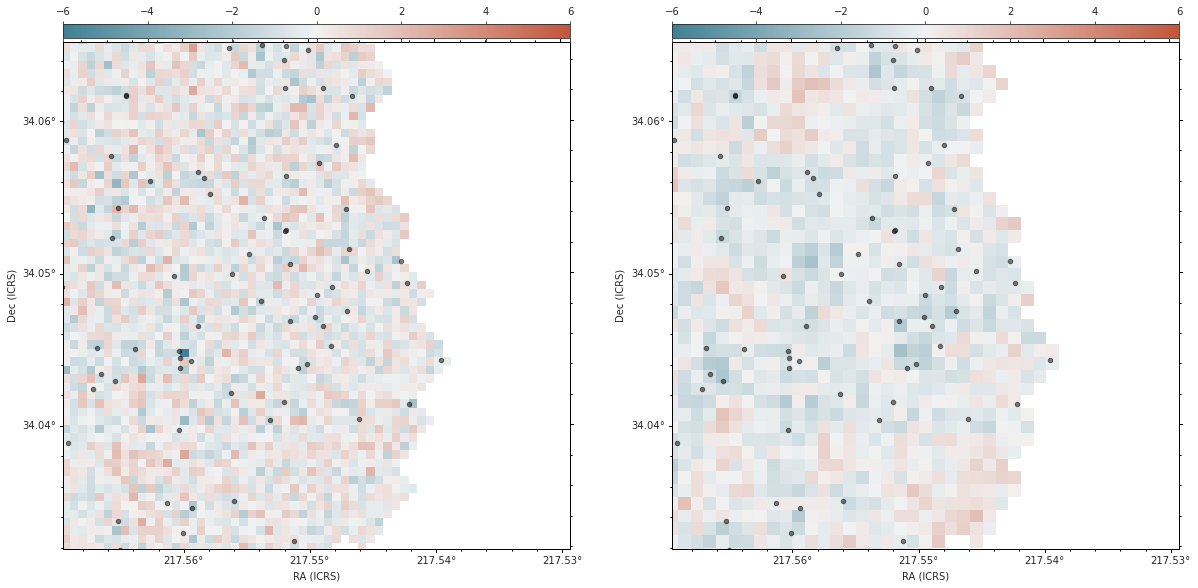

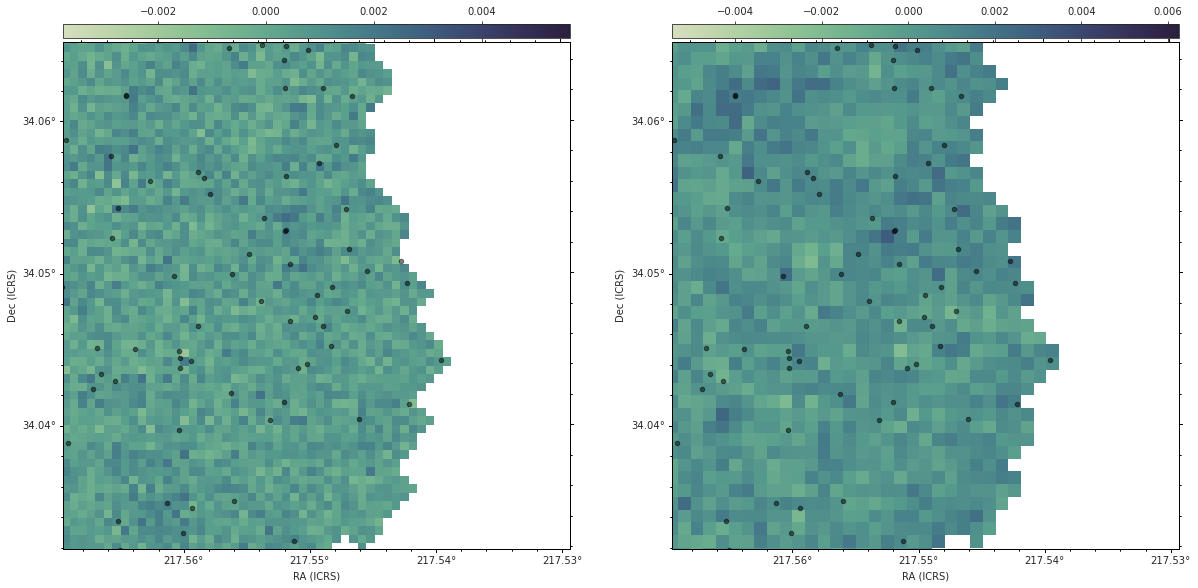

Pval_res_160
------------
       0.179
Pval_res_160
------------
       0.179


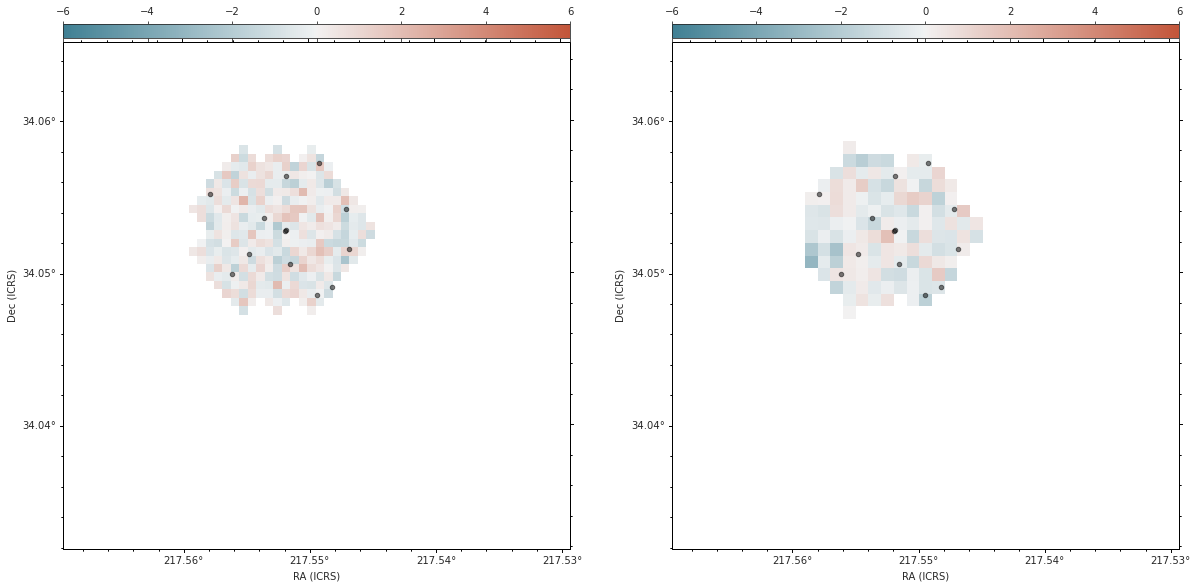

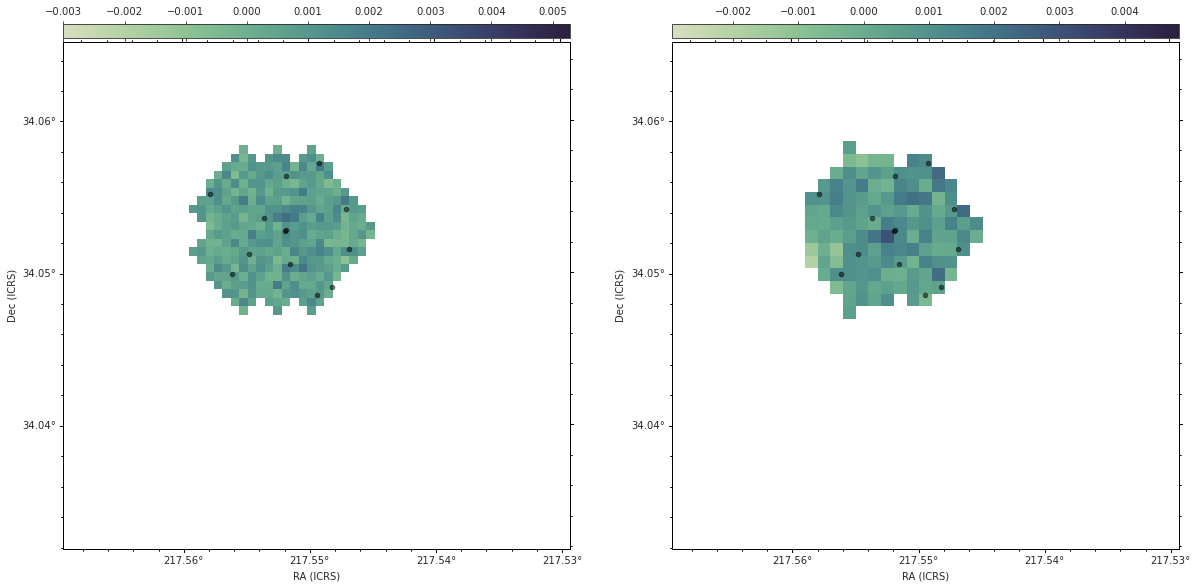

Pval_res_160
------------
        0.77
Pval_res_160
------------
        0.77


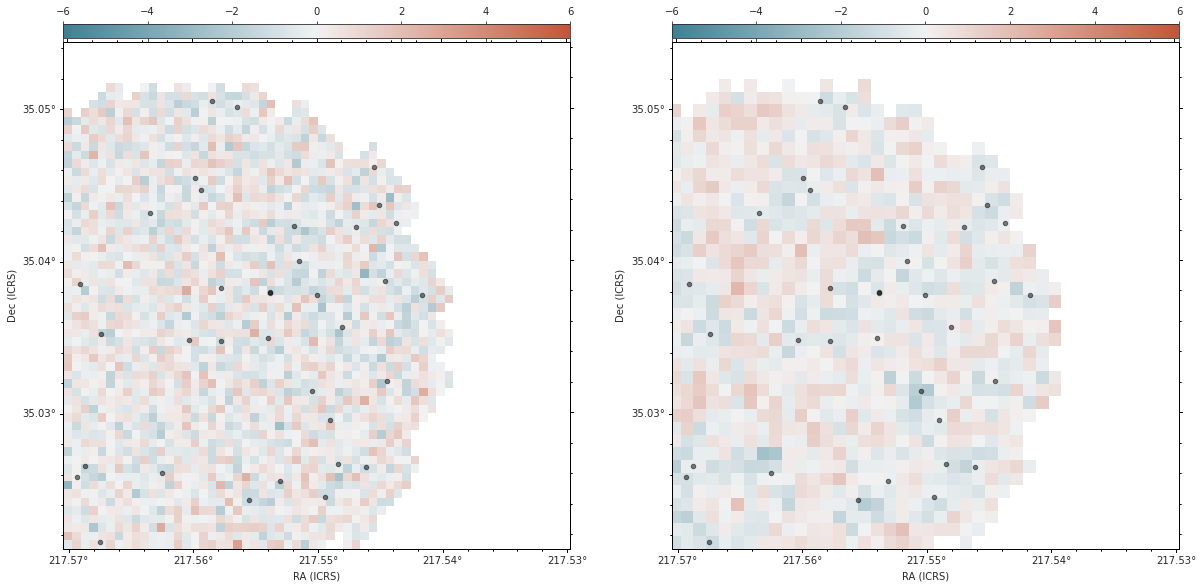

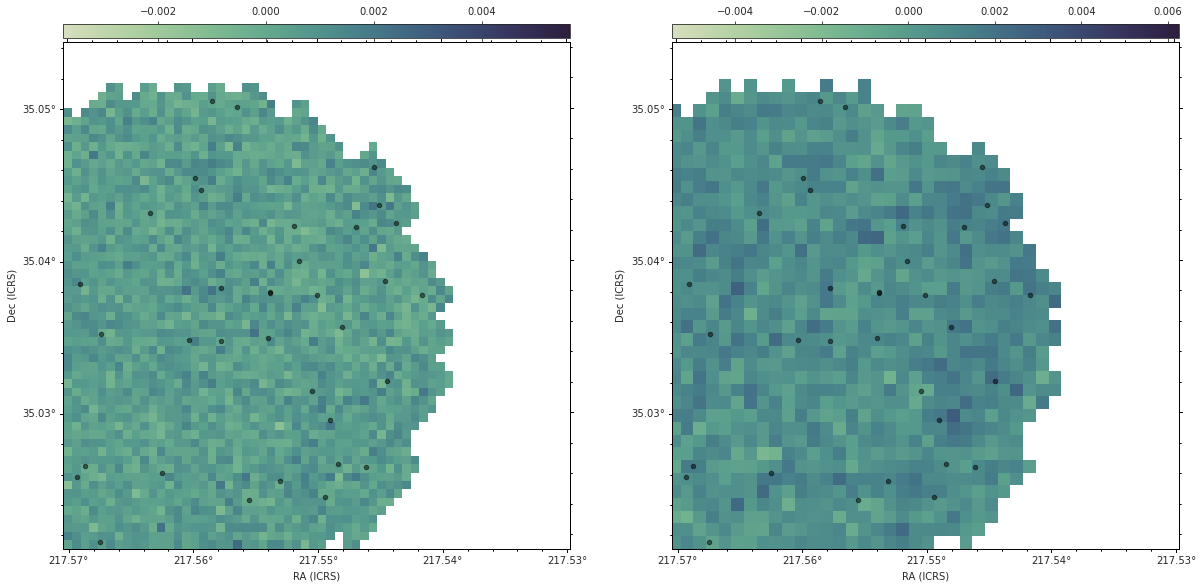

Pval_res_160
------------
       0.097
Pval_res_160
------------
       0.097


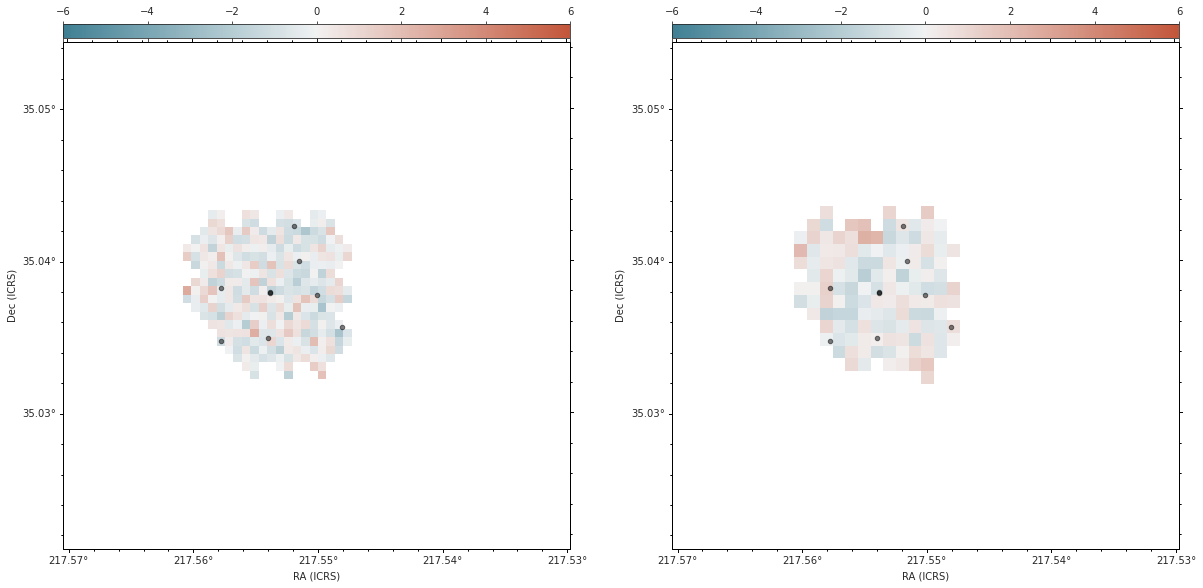

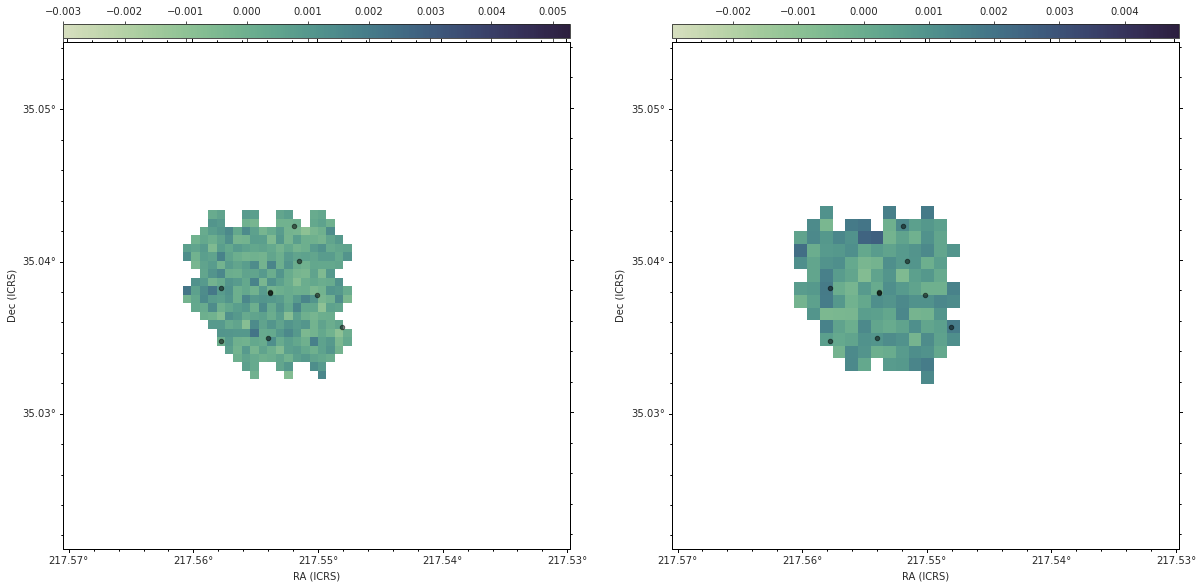

Pval_res_160
------------
       0.983
Pval_res_160
------------
       0.983


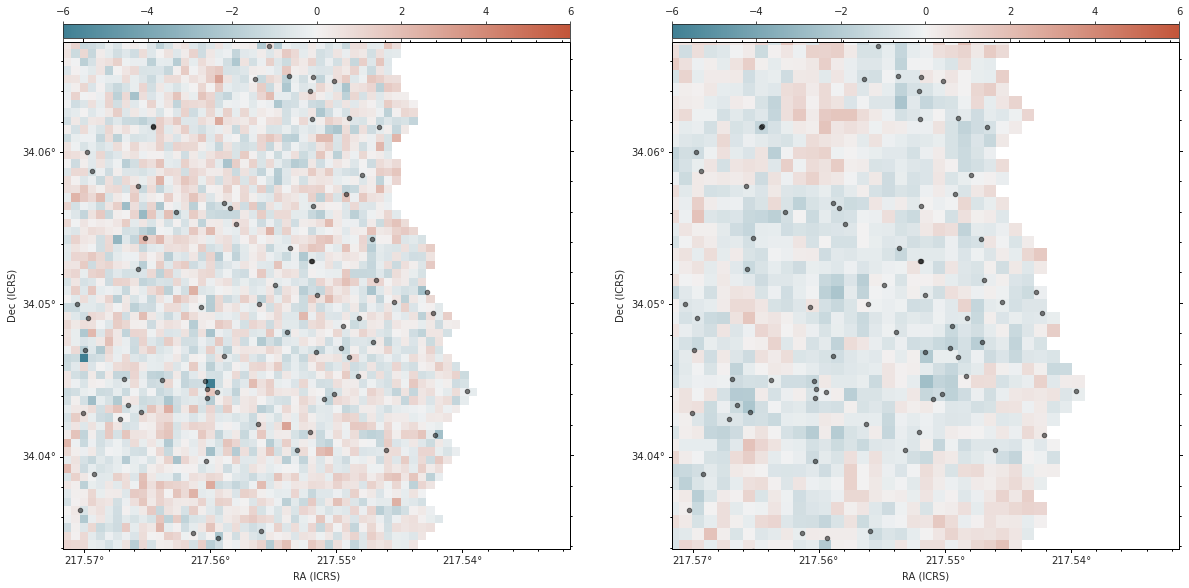

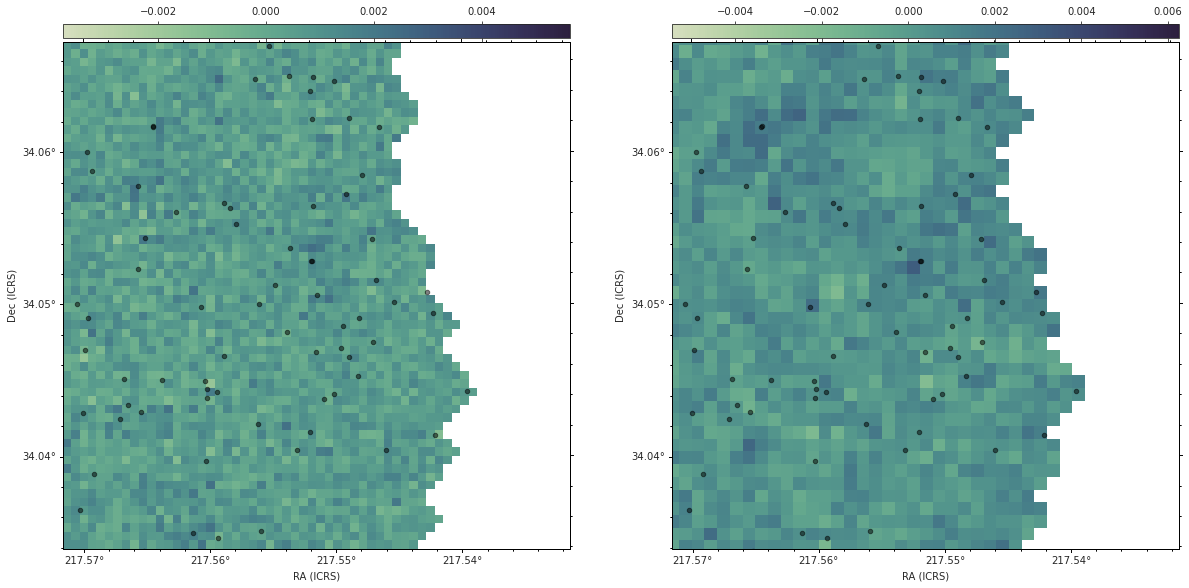

Pval_res_160
------------
       0.202
Pval_res_160
------------
       0.202


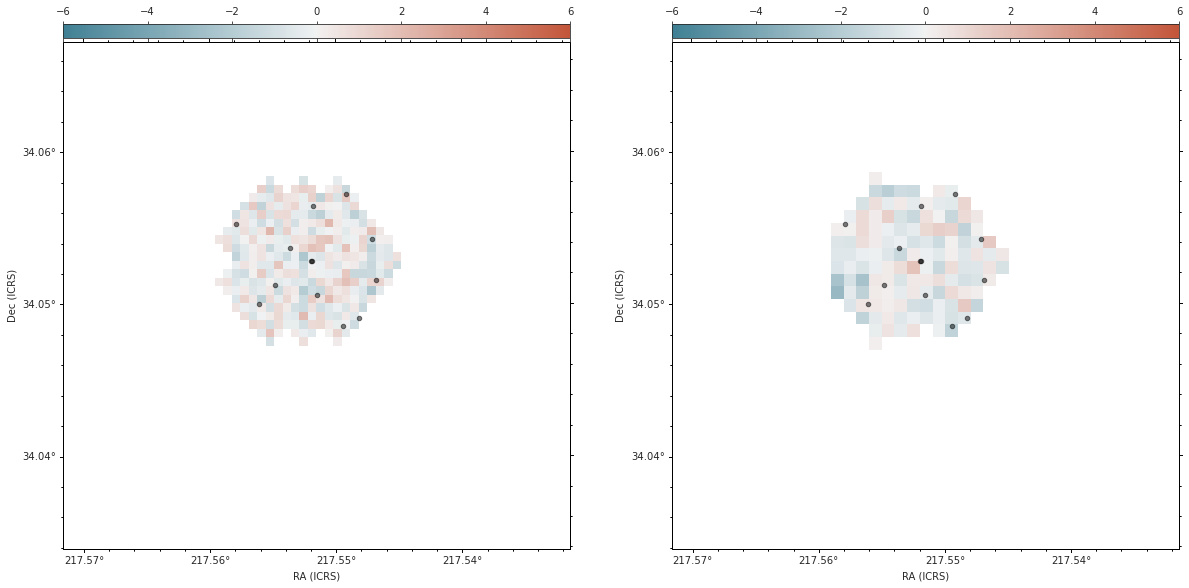

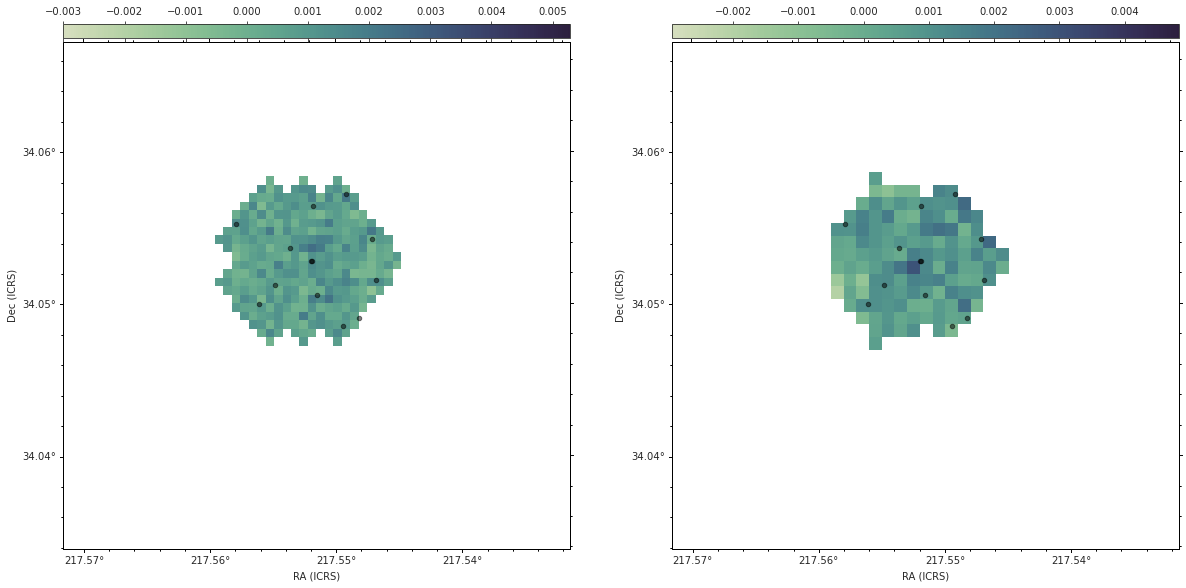

KeyboardInterrupt: 

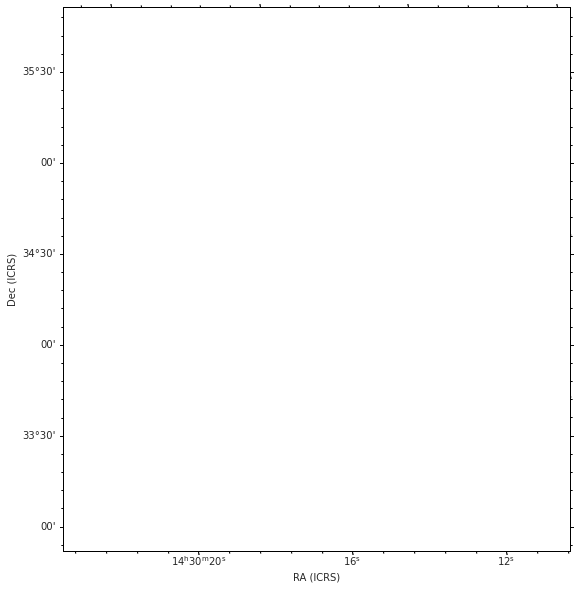

In [251]:
for n in range(len(inds_stan)):
    ind_stan = inds_stan[n]
    ind_numpyro = inds_numpyro[n]
    
    file_name = file_list_numpyro[ind_numpyro]
    
    priors,posterior = xidplus.load(file_name)
    PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
    PACS_cat = Table.read(PACS_cat,memmap=False)
    mask = PACS_cat['help_id'] == names_numpyro[n]
    figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)
    ra = PACS_cat['RA'][mask]
    dec = PACS_cat['Dec'][mask]
    print(PACS_cat['Pval_res_160'][mask])
    figs[0].recenter(ra,dec,radius=1/60)
    figs[1].recenter(ra,dec,radius=1/60)
    
    figs, fig=xidplus.plot_map(priors)
    ra = PACS_cat['RA'][mask]
    dec = PACS_cat['Dec'][mask]
    print(PACS_cat['Pval_res_160'][mask])
    figs[0].recenter(ra,dec,radius=1/60)
    figs[1].recenter(ra,dec,radius=1/60)
    plt.show()
    
    file_name = file_list_stan[ind_stan]
    
    priors,posterior = xidplus.load(file_name)
    PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
    PACS_cat = Table.read(PACS_cat,memmap=False)
    mask = PACS_cat['help_id'] == names_stan[n]
    figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)
    ra = PACS_cat['RA'][mask]
    dec = PACS_cat['Dec'][mask]
    print(PACS_cat['Pval_res_160'][mask])
    figs[0].recenter(ra,dec,radius=1/60)
    figs[1].recenter(ra,dec,radius=1/60)
    
    figs, fig=xidplus.plot_map(priors)
    ra = PACS_cat['RA'][mask]
    dec = PACS_cat['Dec'][mask]
    print(PACS_cat['Pval_res_160'][mask])
    figs[0].recenter(ra,dec,radius=1/60)
    figs[1].recenter(ra,dec,radius=1/60)
    plt.show()

Rhat_PACS_160
-------------
     1.358074 n_eff_PACS_160
--------------
      7.612758


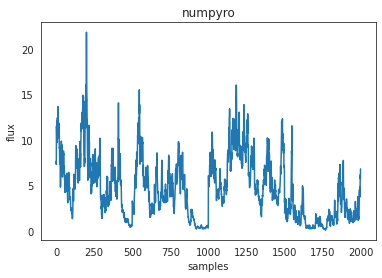

Rhat_PACS_160
-------------
    1.0064157 n_eff_PACS_160
--------------
      836.2118


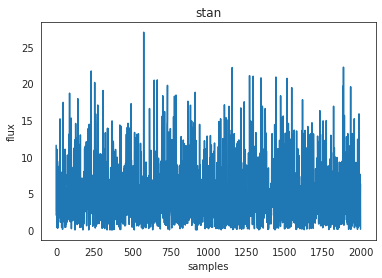

Rhat_PACS_160
-------------
    3.7993083 n_eff_PACS_160
--------------
     2.4762936


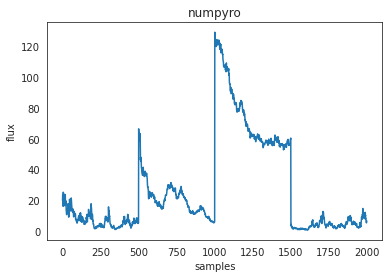

Rhat_PACS_160
-------------
    1.0035511 n_eff_PACS_160
--------------
      481.2977


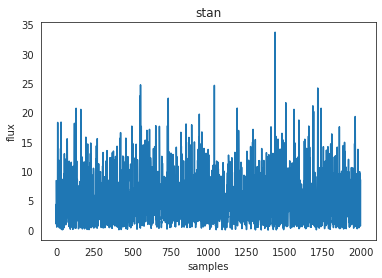

Rhat_PACS_160
-------------
    1.4424076 n_eff_PACS_160
--------------
     10.373519


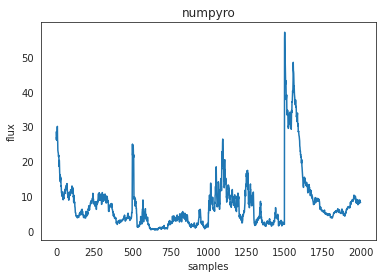

Rhat_PACS_160
-------------
    1.0023528 n_eff_PACS_160
--------------
     463.73563


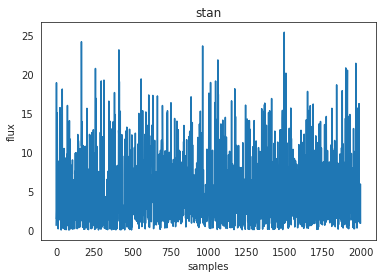

Rhat_PACS_160
-------------
    2.3558092 n_eff_PACS_160
--------------
      4.187821


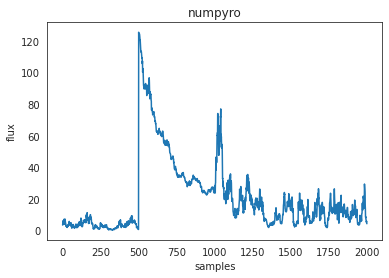

Rhat_PACS_160
-------------
    1.0037042 n_eff_PACS_160
--------------
     442.65082


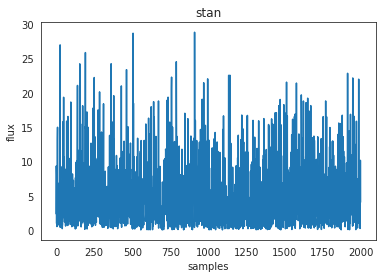

Rhat_PACS_160
-------------
    3.9029467 n_eff_PACS_160
--------------
     2.4871159


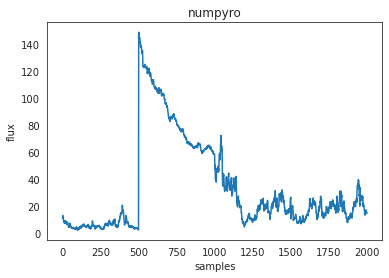

Rhat_PACS_160
-------------
    1.0170666 n_eff_PACS_160
--------------
      251.1602


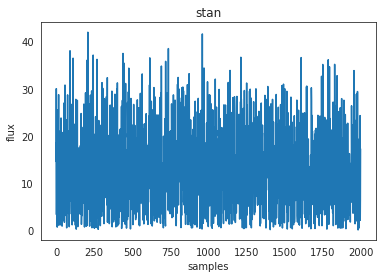

Rhat_PACS_160
-------------
    1.9381946 n_eff_PACS_160
--------------
     4.8039308


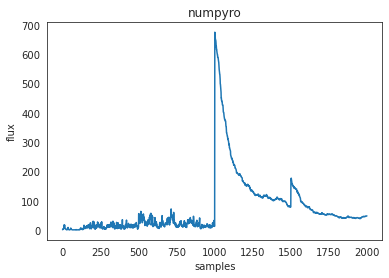

Rhat_PACS_160
-------------
    1.0085614 n_eff_PACS_160
--------------
      242.4301


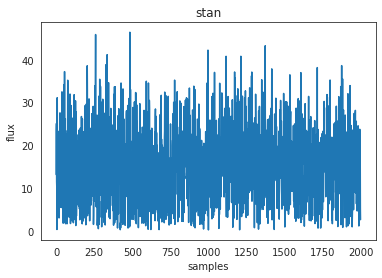

KeyboardInterrupt: 

In [256]:
for n in range(len(inds_stan)):
    ind_stan = inds_stan[n]
    ind_numpyro = inds_numpyro[n]
    
    file_name = file_list_numpyro[ind_numpyro]
    
    priors,posterior = xidplus.load(file_name)
    PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
    PACS_cat = Table.read(PACS_cat,memmap=False)
    mask = PACS_cat['help_id'] == names_numpyro[n]

    print(PACS_cat['Rhat_PACS_160'][mask],PACS_cat['n_eff_PACS_160'][mask])
    y = posterior.samples['src_f'][:,1,mask]
    x = np.arange(0,len(y),1)
    plt.plot(x,y)
    plt.title('numpyro')
    plt.xlabel('samples')
    plt.ylabel('flux')
    plt.show()
    
    file_name = file_list_stan[ind_stan]
    
    priors,posterior = xidplus.load(file_name)
    PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])
    PACS_cat = Table.read(PACS_cat,memmap=False)
    mask = PACS_cat['help_id'] == names_stan[n]

    print(PACS_cat['Rhat_PACS_160'][mask],PACS_cat['n_eff_PACS_160'][mask])
    y = posterior.samples['src_f'][:,1,mask]
    x = np.arange(0,len(y),1)
    plt.plot(x,y)
    plt.title('stan')
    plt.xlabel('samples')
    plt.ylabel('flux')
    plt.show()